In [1]:
# Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, ConfusionMatrixDisplay, \
                            log_loss, precision_recall_curve, roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split, PredefinedSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression

from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from keras import metrics

sns.set(style="darkgrid")  # default style
tf.get_logger().setLevel('INFO')

In [2]:
# Load Data 
features = pd.read_csv('../data/features.csv')
display(features.head())
print(features.columns)

,rotten_tomatoes_link,movie_title,movie_info,runtime,runtime_difference_from_average,critics_consensus,content_rating,original_release_date,streaming_release_date,original_release_quarter,...,horror,kids&family,musical&performingarts,mystery&suspense,romance,sciencefiction&fantasy,specialinterest,sports&fitness,television,western
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",119.0,19.0,Though it may seem like just another Harry Pot...,3,2010-02-12,2015-11-25,1.0,...,0,0,0,0,0,1,0,0,0,0
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,90.0,10.0,Nicole Holofcener's newest might seem slight i...,5,2010-04-30,2012-09-04,2.0,...,0,0,0,0,0,0,0,0,0,0
2,m/10000_bc,"10,000 B.C.",Mammoth hunter D'Leh (Steven Strait) has long ...,109.0,9.0,With attention strictly paid to style instead ...,4,2008-03-07,2013-06-22,1.0,...,0,0,0,0,0,0,0,0,0,0
3,m/10002516-lost_city,The Lost City,"Fico Fellove (Andy Garcia), an apolitical Hava...",143.0,43.0,"Its heart is in the right place, but what star...",5,2005-09-03,2017-03-23,3.0,...,0,0,0,0,0,0,0,0,0,0
4,m/10002635-bridge_of_san_luis_rey,The Bridge of San Luis Rey,"During the Spanish Inquisition, Franciscan mon...",124.0,24.0,Despite an all-star cast and some impressive v...,3,2005-06-10,2014-07-24,2.0,...,0,0,0,0,0,0,0,0,0,0


Index(['rotten_tomatoes_link', 'movie_title', 'movie_info', 'runtime',
       'runtime_difference_from_average', 'critics_consensus',
       'content_rating', 'original_release_date', 'streaming_release_date',
       'original_release_quarter', 'streaming_release_quarter',
       'original_release_month', 'streaming_release_month',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count', 'oscar_nomination', 'genres_sums',
       'prodComp_sums', 'title_length', 'critic_consensus_length',
       'directors_counts', 'actors_counts', 'actors_value', 'directors_value',
       'action&adventure', 'animation', 'anime&manga',
       'arthouse&international', 'classics', 'comedy', 'cultmovies',
       'documentary', 'drama', 'faith&spirituality', 'gay&lesbian', 'horror',
       'kids&family', 'musical

In [3]:
# Data preperation

# load in desired features
X = features.loc[:,[#'rotten_tomatoes_link', 'movie_title', 'movie_info', 'runtime', ### only using runtime avg
       'runtime_difference_from_average', #'critics_consensus',
       'content_rating', #'original_release_quarter', 'streaming_release_quarter',
        'original_release_month', 'streaming_release_month', 'genres_sums',
       'prodComp_sums', 'title_length', 'critic_consensus_length',
       'directors_counts', 'actors_counts', 'actors_value', 'directors_value',
       'action&adventure', 'animation', 'anime&manga',
       'arthouse&international', 'classics', 'comedy', 'cultmovies',
       'documentary', 'drama', 'faith&spirituality', 'gay&lesbian', 'horror',
       'kids&family', 'musical&performingarts', 'mystery&suspense', 'romance',
       'sciencefiction&fantasy', 'specialinterest', 'sports&fitness',
       'television', 'western']]

# specify target variable
y = features['tomatometer_status']

# train test split
X_train_preval, X_test, y_train_preval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify = y)
# train val split
X_train, X_val, y_train, y_val  = train_test_split(X_train_preval, y_train_preval, test_size=0.25,
                                                   random_state=1234, stratify = y_train_preval) 

display(X.describe()) #Summary stats of features
pd.DataFrame(X.describe()).to_csv('../data/feature_stats.csv', index = True) #save as a csv

,runtime_difference_from_average,content_rating,original_release_month,streaming_release_month,genres_sums,prodComp_sums,title_length,critic_consensus_length,directors_counts,actors_counts,...,horror,kids&family,musical&performingarts,mystery&suspense,romance,sciencefiction&fantasy,specialinterest,sports&fitness,television,western
count,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,...,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000,6510.000000
mean,12.983103,3.944086,6.653610,6.771582,3929.215515,99.850230,16.018126,139.961137,1.140707,28.315054,...,0.095392,0.068664,0.045161,0.204608,0.106144,0.109217,0.059908,0.009831,0.008449,0.007527
std,12.422185,1.230885,3.371682,3.516730,1880.827368,109.494466,9.697941,39.622196,0.744222,22.084903,...,0.293778,0.252901,0.207674,0.403446,0.308046,0.311935,0.237334,0.098671,0.091534,0.086437
min,0.000000,0.000000,1.000000,1.000000,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,3.000000,4.000000,4.000000,2240.000000,10.000000,10.000000,115.000000,1.000000,11.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.000000,4.000000,7.000000,7.000000,3751.000000,51.000000,14.000000,145.000000,1.000000,22.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,17.000000,5.000000,10.000000,10.000000,5288.000000,188.000000,19.000000,166.000000,1.000000,40.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,166.000000,5.000000,12.000000,12.000000,10750.000000,332.000000,99.000000,528.000000,31.000000,194.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:

print(X_train.shape, X_test.shape, X_val.shape) # Check for correct data sizes
test_fold = [0 if x in X_val.index else 1 for x in X_train_preval.index] #specify test fold
ps = PredefinedSplit(test_fold) # set up val as predefined split for grid search


(3906, 33) (1302, 33) (1302, 33)


In [5]:
# Scale Features
scl = StandardScaler()
X_train_preval = scl.fit_transform(X_train_preval) #fit on train+val data
X_train = scl.transform(X_train) # apply scaler
X_val = scl.transform(X_val) # apply scaler
X_test = scl.transform(X_test) # apply scaler


In [6]:
# Build Model --- Using Keras implimentation for testing
def build_model(learning_rate=0.05):
  """Build a TF logistic regression model using Keras.

  Args:
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(1234)
  tf.random.set_seed(1234)

  # Build a model using keras.Sequential.
  model = keras.Sequential()

  model.add(keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      use_bias=True,               # use a bias param
      activation="sigmoid"         # apply the sigmoid function!
  ))

  # Use the SGD optimizer as usual.
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # We specify the binary_crossentropy loss (equivalent to log loss).
  # Notice that we are including 'binary accuracy' as one of the metrics that we
  # ask Tensorflow to report when evaluating the model.
  model.compile(loss='binary_crossentropy', 
                optimizer=optimizer, 
                metrics=[metrics.binary_accuracy])

  return model
logreg_model = build_model()

2022-08-02 23:17:59.028195: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Fit the model.
history = logreg_model.fit(
  x = X_train,   # our binary training examples
  y = y_train,   # corresponding binary labels
  epochs=10,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_data=(X_val, y_val), #specify validation data
  verbose=1             # display some progress output during training
  )

Epoch 1/10
62/62 [==============================] - 1s 5ms/step - loss: 0.7077 - binary_accuracy: 0.5799 - val_loss: 0.6787 - val_binary_accuracy: 0.6068
Epoch 2/10
62/62 [==============================] - 0s 3ms/step - loss: 0.6194 - binary_accuracy: 0.6536 - val_loss: 0.6368 - val_binary_accuracy: 0.6551
Epoch 3/10
62/62 [==============================] - 0s 3ms/step - loss: 0.5967 - binary_accuracy: 0.6792 - val_loss: 0.6201 - val_binary_accuracy: 0.6621
Epoch 4/10
62/62 [==============================] - 0s 3ms/step - loss: 0.5874 - binary_accuracy: 0.6854 - val_loss: 0.6132 - val_binary_accuracy: 0.6782
Epoch 5/10
62/62 [==============================] - 0s 3ms/step - loss: 0.5825 - binary_accuracy: 0.6928 - val_loss: 0.6075 - val_binary_accuracy: 0.6736
Epoch 6/10
62/62 [==============================] - 0s 4ms/step - loss: 0.5794 - binary_accuracy: 0.6910 - val_loss: 0.6033 - val_binary_accuracy: 0.6720
Epoch 7/10
62/62 [==============================] - 0s 3ms/step - loss: 0.57

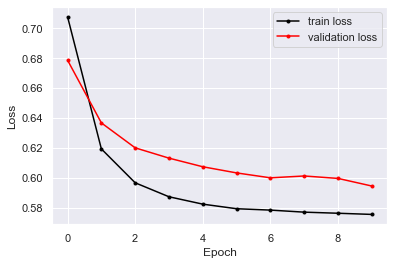

Final train loss: 0.5756181478500366
Final weights: [array([[ 0.33740982],
       [-0.22538581],
       [ 0.13628995],
       [-0.00725405],
       [ 0.18813995],
       [-0.06761076],
       [ 0.01238246],
       [ 0.30262923],
       [ 0.03962934],
       [-0.1149571 ],
       [-0.16811955],
       [ 0.16953169],
       [-0.22703381],
       [ 0.1408948 ],
       [-0.02536467],
       [ 0.3685892 ],
       [-0.04889213],
       [-0.16937616],
       [ 0.00707954],
       [ 0.61458063],
       [ 0.1002059 ],
       [-0.02567321],
       [ 0.07224728],
       [-0.14227861],
       [-0.143321  ],
       [-0.01826552],
       [-0.13589524],
       [-0.17731631],
       [-0.00182685],
       [ 0.01606611],
       [ 0.0430883 ],
       [ 0.01776743],
       [ 0.02385532]], dtype=float32), array([0.32409942], dtype=float32)]


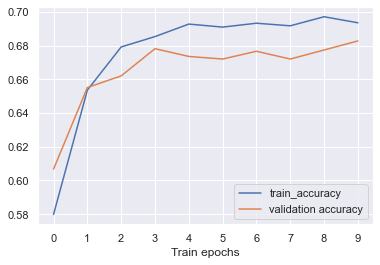

Final train accuracy: 0.6935483813285828
41/41 [==============================] - 0s 2ms/step - loss: 0.5951 - binary_accuracy: 0.6843
[0.595131516456604, 0.6843317747116089]


In [8]:
def plot_loss(model, history):
  """Plot the loss after each training epoch."""
  # Convert the history object into a DataFrame.
  history = pd.DataFrame(history.history)

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(range(len(history)), history['loss'], marker='.', color='black')
  plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
  plt.legend(['train loss', 'validation loss'])
  plt.show()

  # Show the final train loss value and the learned model weights.
  print('Final train loss:', list(history['loss'])[-1])
  print('Final weights:', model.layers[0].get_weights())

plot_loss(logreg_model, history)

def plot_acc(model, history, num_epochs=10):
    train_accuracy = history.history['binary_accuracy']
    val_accuracy = history.history['val_binary_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(num_epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()
    
      # Show the final train loss value and the learned model weights.
    print('Final train accuracy:', list(history.history['binary_accuracy'])[-1])
    #print('Final weights:', model.layers[0].get_weights())

plot_acc(logreg_model, history)

print(logreg_model.evaluate(X_test, y_test))

In [28]:
# SKLearn implimentation --- Use for presentation

results = []

# Create a baseline model trained on the train, and validated on val
logisticRegr = LogisticRegression() #specify Log Reg Model
logisticRegr.fit(X_train, y_train) #fit on train data
predictions = logisticRegr.predict(X_val) #predict on val data
score = logisticRegr.score(X_val, y_val) #score
print('Baseline validation accuracy: ', score.round(3))

Baseline validation accuracy:  0.688


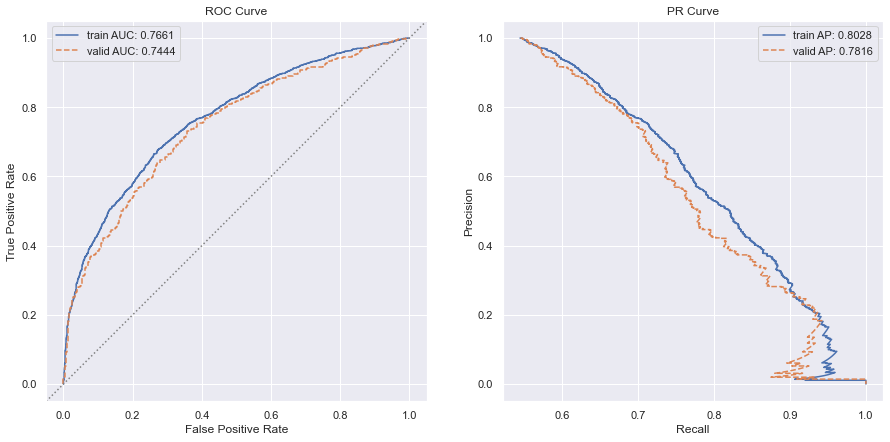

In [29]:
# predict
train_preds = logisticRegr.predict(X_train)
valid_preds = logisticRegr.predict(X_val)

# probs
train_probs = logisticRegr.predict_proba(X_train)
valid_probs = logisticRegr.predict_proba(X_val)

# append to results list
results.append({'model': 'Untuned (train | val)', 'accuracy': score.round(3), 
                'train_auc': round(roc_auc_score(y_train, train_probs[:,1]),4),
                'test_auc': round(roc_auc_score(y_val, valid_probs[:,1]),4),
                'train_AP': round(average_precision_score(y_train, train_probs[:,1]),4),
                'test_AP': round(average_precision_score(y_val, valid_probs[:,1]),4)})

# auc
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

fpr_train, tpr_train, _ = roc_curve(y_train, train_probs[:,1])
fpr_valid, tpr_valid, _ = roc_curve(y_val, valid_probs[:,1])

# pr
prec_train, recall_train, _ = precision_recall_curve(y_train, train_probs[:,1])
prec_valid, recall_valid, _ = precision_recall_curve(y_val, valid_probs[:,1])

ax1.plot(fpr_train, tpr_train, label=f'train AUC: {round(roc_auc_score(y_train, train_probs[:,1]),4)}')
ax1.plot(fpr_valid, tpr_valid, label=f'valid AUC: {round(roc_auc_score(y_val, valid_probs[:,1]),4)}', 
         linestyle='--')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, label=f'train AP: {round(average_precision_score(y_train, train_probs[:,1]),4)}')
ax2.plot(prec_valid, recall_valid, label=f'valid AP: {round(average_precision_score(y_val, valid_probs[:,1]),4)}', 
         linestyle='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()

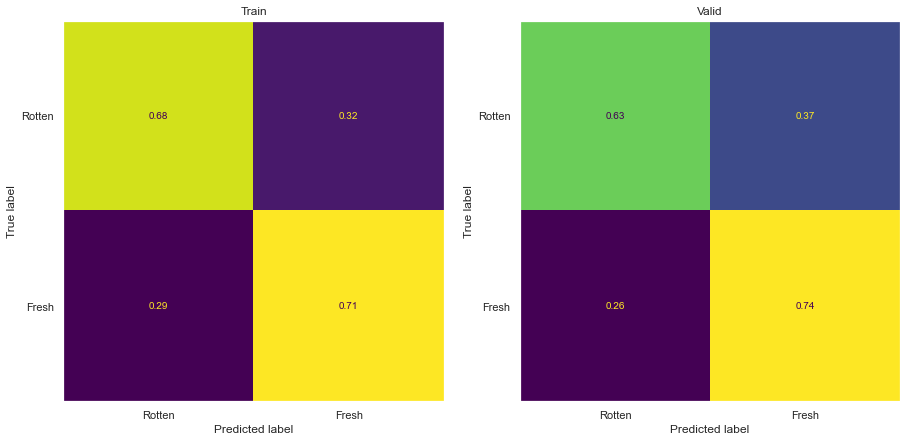

In [30]:
# confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

cm_train = confusion_matrix(y_train, train_preds,
                            normalize='true')

cm_valid = confusion_matrix(y_val, valid_preds,
                            normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm_train,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_valid,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax2, colorbar=False)

ax1.set_title('Train')
ax2.set_title('Valid')
ax1.grid()
ax2.grid()
plt.show()

In [31]:
def report(results, n_top=3): # generate function for printing top model report from hyperparameter tuning
    for i in range(1, n_top + 1):
        candidate = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidate:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],))
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")

# set up param grid for hypterparameter tuning
param_grid = [{'penalty' : ['l1', 'l2', 'elasticnet'], 'C' : np.logspace(-4, 4, 20), 'solver' : ['liblinear']}]

#clf = GridSearchCV(logisticRegr, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# use grid search CV for hyperparam tuning - predefined split is the cv data (val data)
clf = GridSearchCV(logisticRegr, param_grid = param_grid, cv = ps, verbose=True, n_jobs=-1)

# Fit on data
#best_clf = clf.fit(X_train, y_train)
best_clf = clf.fit(X_train_preval, y_train_preval) #use preval because we have val data indeces specified 

Fitting 2 folds for each of 60 candidates, totalling 120 fits



40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dimitriospsaltos/anaconda3/envs/w207/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dimitriospsaltos/anaconda3/envs/w207/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/dimitriospsaltos/anaconda3/envs/w207/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py", line 71, in _check_solver
    raise ValueError(
ValueError: Only 's

In [32]:
# Print best estimator
best_clf.best_estimator_

LogisticRegression(C=0.23357214690901212, penalty='l1', solver='liblinear')

In [33]:
# Print best fit score
print('best fit score: ', best_clf.best_score_)

best fit score:  0.6865079365079365


In [34]:
# Show top models
report(best_clf.cv_results_)


Model with rank: 1
Mean validation score: 0.687 (std: 0.002)
Parameters: {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}

Model with rank: 2
Mean validation score: 0.686 (std: 0.000)
Parameters: {'C': 0.08858667904100823, 'penalty': 'l1', 'solver': 'liblinear'}

Model with rank: 3
Mean validation score: 0.685 (std: 0.004)
Parameters: {'C': 0.03359818286283781, 'penalty': 'l2', 'solver': 'liblinear'}



In [35]:
# Print best parameters
print('best parameters: ',best_clf.best_params_)

best parameters:  {'C': 0.23357214690901212, 'penalty': 'l1', 'solver': 'liblinear'}


In [36]:
# Test tuned model trained on train data vs val set
logisticRegr2 = LogisticRegression(C=best_clf.best_params_['C'], 
                                 penalty=best_clf.best_params_['penalty'],
                                 solver=best_clf.best_params_['solver']) #specify Log Reg Model
logisticRegr2.fit(X_train, y_train)
# predict
train_preds = logisticRegr2.predict(X_train)
valid_preds = logisticRegr2.predict(X_val)

# probs
train_probs = logisticRegr2.predict_proba(X_train)
valid_probs = logisticRegr2.predict_proba(X_val)

#score results
score = logisticRegr2.score(X_val, y_val) #score

# append to results list
results.append({'model': 'Tuned (train | val)', 'accuracy': score.round(3), 
                'train_auc': round(roc_auc_score(y_train, train_probs[:,1]),4),
                'test_auc': round(roc_auc_score(y_val, valid_probs[:,1]),4),
                'train_AP': round(average_precision_score(y_train, train_probs[:,1]),4),
                'test_AP': round(average_precision_score(y_val, valid_probs[:,1]),4)})

In [37]:
# Build final Model - build on train + val using top hyperparameters
final_logReg = LogisticRegression(C=best_clf.best_params_['C'], 
                                 penalty=best_clf.best_params_['penalty'],
                                 solver=best_clf.best_params_['solver'])
final_logReg = final_logReg.fit(X_train_preval, y_train_preval) #fit on train + val data
final_logReg

LogisticRegression(C=0.23357214690901212, penalty='l1', solver='liblinear')

In [38]:
# Run on the Test Data
test_probs = final_logReg.predict_proba(X_test) #predict test data probs
train_preval_probs = final_logReg.predict_proba(X_train_preval) #predict train + val data probs
test_preds = (test_probs[:,1] >= 0.5).astype(bool) # generate test preds
train_preval_preds = (train_preval_probs[:,1] >= 0.5).astype(bool) #generate train + val preds
print(final_logReg.score(X_test, y_test)) # results
print(classification_report(y_test, test_preds)) # classification report

0.6774193548387096
              precision    recall  f1-score   support

         0.0       0.65      0.64      0.64       593
         1.0       0.70      0.71      0.71       709

    accuracy                           0.68      1302
   macro avg       0.67      0.67      0.67      1302
weighted avg       0.68      0.68      0.68      1302



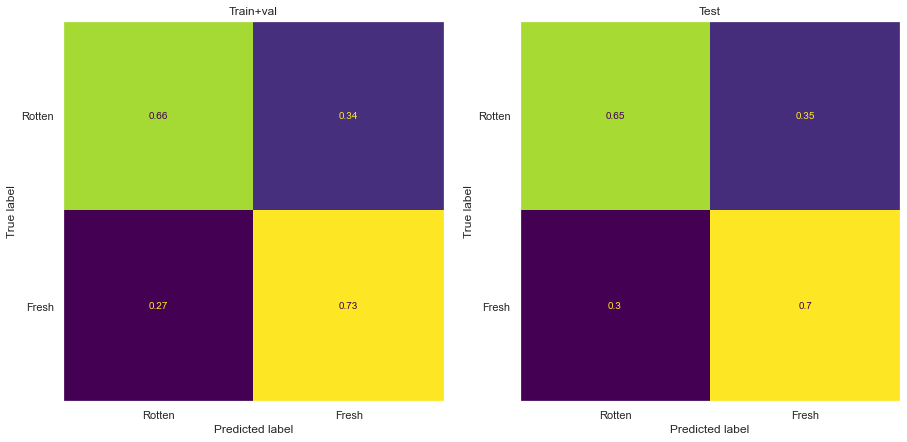

In [39]:
# confusion matrix
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

cm_train = confusion_matrix(train_preval_preds, y_train_preval,
                            normalize='true')

cm_valid = confusion_matrix(test_preds, y_test,
                            normalize='true')

ConfusionMatrixDisplay(confusion_matrix=cm_train,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax1, colorbar=False)
ConfusionMatrixDisplay(confusion_matrix=cm_valid,
                       display_labels=['Rotten', 'Fresh']).plot(ax=ax2, colorbar=False)

ax1.set_title('Train+val')
ax2.set_title('Test')
ax1.grid()
ax2.grid()
plt.show()

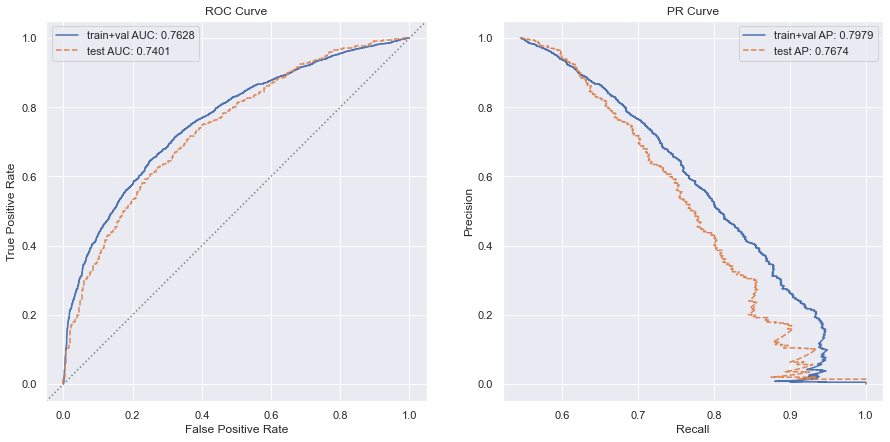

In [40]:
# auc
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

fpr_train, tpr_train, _ = roc_curve(y_train_preval, train_preval_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test, test_probs[:,1])

fpr_train = sorted(fpr_train)
tpr_train = sorted(tpr_train)
fpr_test = sorted(fpr_test)
tpr_test = sorted(tpr_test)

results.append({'model': 'Tuned (train + val | test)', 'accuracy': final_logReg.score(X_test, y_test).round(3), 
                'train_auc': round(roc_auc_score(y_train_preval, train_preval_probs[:,1]),4),
                'test_auc': round(roc_auc_score(y_test, test_probs[:,1]),4),
                'train_AP': round(average_precision_score(y_train_preval, train_preval_probs[:,1]),4),
                'test_AP': round(average_precision_score(y_test, test_probs[:,1]),4)})

# pr
prec_train, recall_train, _ = precision_recall_curve(y_train_preval, train_preval_probs[:,1])
prec_test, recall_test, _ = precision_recall_curve(y_test, test_probs[:,1])

ax1.plot(fpr_train, tpr_train, label=f'train+val AUC: {round(roc_auc_score(y_train_preval, train_preval_probs[:,1]),4)}')
ax1.plot(fpr_test, tpr_test, label=f'test AUC: {round(roc_auc_score(y_test, test_probs[:,1]),4)}', 
         linestyle='--')
ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, color='gray', linestyle=':')

ax2.plot(prec_train, recall_train, label=f'train+val AP: {round(average_precision_score(y_train_preval, train_preval_probs[:,1]),4)}')
ax2.plot(prec_test, recall_test, label=f'test AP: {round(average_precision_score(y_test, test_probs[:,1]),4)}', 
         linestyle='--')

ax1.legend(loc=0)
ax2.legend(loc=0)

ax1.set_title('ROC Curve')
ax2.set_title('PR Curve')

ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

plt.show()

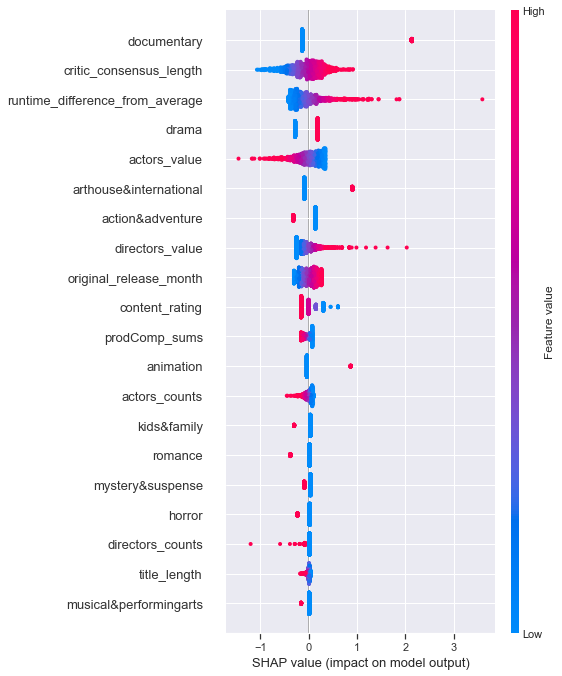

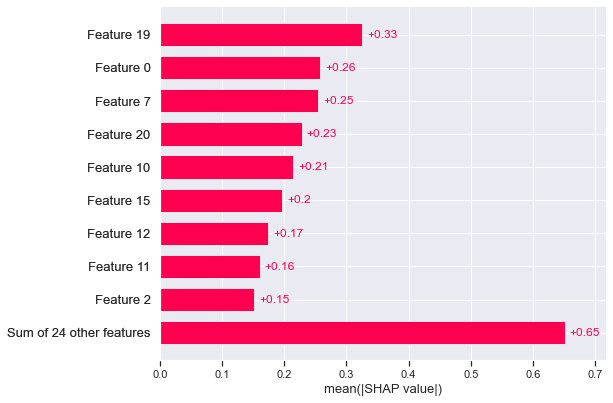

Index(['documentary', 'runtime_difference_from_average',
       'critic_consensus_length', 'drama', 'actors_value',
       'arthouse&international', 'action&adventure', 'directors_value',
       'original_release_month'],
      dtype='object')


In [41]:
# Try Shap for Logsitic regression feature explaination
from shap import LinearExplainer, summary_plot, plots
explainer = LinearExplainer(final_logReg, X_train_preval) #build explainer from final model and train + val data
shap_values = explainer.shap_values(X_test) #show explainer on test data
summary_plot(shap_values, X_test, feature_names=X.columns) # show summary plot
plots.bar(explainer(X_train_preval)) #bar plot for testing
print(X.columns[[19, 0, 7, 20, 10, 15, 12, 11, 2]]) #print incedes 

[[ 0.35706813 -0.18779321  0.17431592  0.          0.         -0.07617159
  -0.031244    0.32848007 -0.08026475 -0.07315154 -0.2661527   0.22604576
  -0.18434391  0.19088108 -0.02562471  0.33575111 -0.06251392 -0.01574221
  -0.04416943  0.66519998  0.2319433  -0.05031187  0.0547618  -0.0733019
  -0.08607629 -0.03423213 -0.05085167 -0.12316558  0.0058765   0.
   0.04033813  0.01352054  0.04287677]]


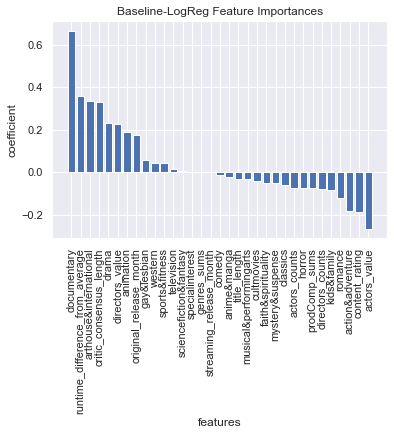

In [42]:
# features
feature_importances = final_logReg.coef_ #get model coefficients
print(feature_importances) # print their importances

# create data frame for feature importances
feature_importances_df = pd.DataFrame({'features': X.columns, 
                                       'importance': feature_importances[0],
                                      'shap_importance': shap_values[0]}).sort_values('importance', ascending=False)

plt.bar(x=feature_importances_df.features, height=feature_importances_df.importance) #create barplot
#plt.bar(x=feature_importances_df.features, height=feature_importances_df.shap_importance)
plt.xlabel('features')
plt.ylabel('coefficient')
plt.title('Baseline-LogReg Feature Importances')
plt.xticks(rotation=90)
plt.show()

In [43]:
print(X.columns)
X.columns.__len__()

Index(['runtime_difference_from_average', 'content_rating',
       'original_release_month', 'streaming_release_month', 'genres_sums',
       'prodComp_sums', 'title_length', 'critic_consensus_length',
       'directors_counts', 'actors_counts', 'actors_value', 'directors_value',
       'action&adventure', 'animation', 'anime&manga',
       'arthouse&international', 'classics', 'comedy', 'cultmovies',
       'documentary', 'drama', 'faith&spirituality', 'gay&lesbian', 'horror',
       'kids&family', 'musical&performingarts', 'mystery&suspense', 'romance',
       'sciencefiction&fantasy', 'specialinterest', 'sports&fitness',
       'television', 'western'],
      dtype='object')


33

In [44]:
pd.DataFrame(results)

,model,accuracy,train_auc,test_auc,train_AP,test_AP
0,Untuned (train | val),0.688,0.7661,0.7444,0.8028,0.7816
1,Tuned (train | val),0.689,0.7659,0.7439,0.8028,0.7809
2,Tuned (train + val | test),0.677,0.7628,0.7401,0.7979,0.7674
